In [1]:
#Install the proper libraries needed
!pip install Pillow
!pip install matplotlib
!pip install py2neo==2.0
!pip install boto3
!pip install jgraph

from PIL import Image
import webbrowser
import datetime
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import json
from pprint import pprint
import boto3
import jgraph
from py2neo import Graph, authenticate, Relationship
import urllib
from scripts.rekgraph import rekrelationships
%matplotlib inline


    100% |████████████████████████████████| 112kB 5.1MB/s eta 0:00:01
  Running setup.py bdist_wheel for olefile ... - done
  Stored in directory: /home/ubuntu/.cache/pip/wheels/4b/f4/11/bc4166107c27f07fd7bba707ffcb439619197638a1ac986df3
Successfully built olefile
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 256kB 3.5MB/s eta 0:00:01
  Running setup.py bdist_wheel for py2neo ... - \ | done
  Stored in directory: /home/ubuntu/.cache/pip/wheels/c8/c2/d7/bf9c1d0920f010d3f4535e642466b5d145b88cf0d53060977c
Successfully built py2neo
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |█████████████████████

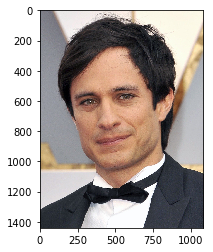

In [16]:
#retrieve and print a selected image
#use the same file name for each temp image or you will start getting a ton of photos
#stored in the folder
urllib.urlretrieve("https://s3.amazonaws.com/cf-templates-1c26sg3g0f07u-us-east-1/163723_v9_bb.jpg", "images/image1.jpg")                                                               
imshow(np.asarray(Image.open('images/image1.jpg', 'r')))

data type and length of the response from the detect_faces call
<type 'dict'>
2
the number of faces detected in the picture
1
printing face bounding boxes below

face number 0
0.0981481447816
0.207638889551
0.667592585087
0.500694453716
width 1080
height 1440


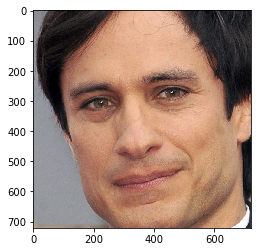

In [17]:
#detect faces in the first picture in the image
client = boto3.client('rekognition', region_name='us-east-1')
response = client.detect_faces(
    Image={
        'Bytes': open('images/image1.jpg','rb').read().strip()
    }
)
#the api returns a json dictionary of length 3
print('data type and length of the response from the detect_faces call')
print(type(response))
print(len(response))
 
#parsing out that dictionary
#print (response['ResponseMetadata'])
#print()
#print (response['FaceDetails'])
#print()
#print (response['OrientationCorrection'])
 
#print how many faces are in this picture
print('the number of faces detected in the picture')
faceCount=len(response['FaceDetails'])
print(faceCount)
 
if(faceCount>0):
    #next step is to show only the cropped faces
    #the IndexFaces api call will automatically take care of this parsing
    #for you when sending pictures with multiple faces to a FaceCollection.
    print('printing face bounding boxes below')
    counter=0
    #which of the faces from the photo do you want to print? rekognition makes the
    #largest face equal to index zero
    faceNumToKeep=0
    #these toKeep____ variables are to give flexibility
    #on which face to crop and print
    toKeepLeft=0.0
    toKeepTop=0.0
    toKeepWidth=0.0
    toKeepHeight=0.0
 
    #if you care to see the raw data that we parse in the for loop below
    #boundingBox=response['FaceDetails'][0]['BoundingBox']
    #print(boundingBox)
 
    #loop over each face and print the bounding boxes, save the one
    #specified by the faceNumToKeep param
    #for pictures with multiple faces, Rekognition starts with the largest face and moves iteratively to smaller ones
    for x in response['FaceDetails']:
        print('\nface number '+str(counter))
        boundingBox=x['BoundingBox']
        #print(boundingBox)
        print(boundingBox['Left'])
        print(boundingBox['Top'])
        print(boundingBox['Width'])
        print(boundingBox['Height'])
        if (counter==faceNumToKeep):
            toKeepLeft=boundingBox['Left']
            toKeepTop=boundingBox['Top']
            toKeepWidth=boundingBox['Width']
            toKeepHeight=boundingBox['Height']
        counter=counter+1
   
    #retrieve the whole photo, crop the face of interest and print                                                                 
    pil_im = Image.open('images/image1.jpg', 'r')
   
    picwidth=pil_im.size[0]
    picheight=pil_im.size[1]
    print('width '+str(picwidth))
    print('height '+str(picheight))
    imshow(np.asarray(pil_im.crop((
        picwidth*toKeepLeft,
        picheight*toKeepTop,
        picwidth*toKeepLeft+picwidth*toKeepWidth,
        picheight*toKeepTop+picheight*toKeepHeight
                             ))))
 

In [18]:
#detect celebrities
response = client.recognize_celebrities(
    Image={
        'Bytes': open('images/image1.jpg','rb').read().strip()
    }
)

print ('num celebrities found: '+str(len(response['CelebrityFaces'])))
for i in response['CelebrityFaces']:
    print i['Name']
    imageName = i['Name']
name1=response['CelebrityFaces'][0]['Name']

num celebrities found: 1
Gael García Bernal


In [19]:
authenticate("localhost:7474", "neo4j", "Matrixmty2016&")
graph = Graph()
graph.neo4j_version

(3, 1, 7)

In [20]:
query="""
MATCH p=shortestPath(
  (p1:Person {name:"Kevin Bacon"})-[*]-(p2:Person {name:"Michael Dorman"})
)
UNWIND nodes(p) as n
RETURN n.name, n.title
"""
result=graph.cypher.execute(query)
result

   | n.name         | n.title             
---+----------------+----------------------
 1 | Kevin Bacon    |                     
 2 |                | New York, I Love You
 3 | Mira Nair      |                     
 4 |                | Amelia              
 5 | Mia Wasikowska |                     
 6 |                | Suburban Mayhem     
 7 | Michael Dorman |                     

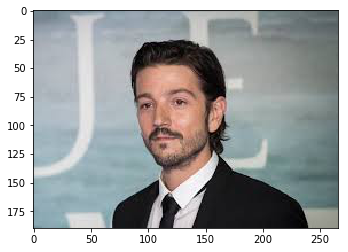

In [28]:
#now we bring it all together: bring in a second photo, and retrieve how the two actors/actresses know each other
urllib.urlretrieve("https://s3.amazonaws.com/cf-templates-1c26sg3g0f07u-us-east-1/download.jpg", "images/image2.jpg")                                                               
imshow(np.asarray(Image.open('images/image2.jpg', 'r')))

In [29]:
response = client.recognize_celebrities(
    Image={
        'Bytes': open('images/image2.jpg','rb').read().strip()
    }
)

print ('num celebrities found: '+str(len(response['CelebrityFaces'])))
for i in response['CelebrityFaces']:
    print i['Name']
    imageName = i['Name']
name2=response['CelebrityFaces'][0]['Name']

num celebrities found: 1
Diego Luna


In [30]:
print "Querying Neo4j for connection between %s and %s!" % (name1, name2)
query="""
MATCH p=shortestPath(
  (p1:Person {name:"%s"})-[*]-(p2:Person {name:"%s"})
)
UNWIND nodes(p) as n
RETURN n.name, n.title
"""%(name1, name2)
print query
result=graph.cypher.execute(query)
print result
rekrelationships(graph,name1,name2)

Querying Neo4j for connection between Gael García Bernal and Diego Luna!

MATCH p=shortestPath(
  (p1:Person {name:"Gael García Bernal"})-[*]-(p2:Person {name:"Diego Luna"})
)
UNWIND nodes(p) as n
RETURN n.name, n.title

   | n.name             | n.title     
---+--------------------+--------------
 1 | Gael García Bernal |             
 2 |                    | Rudo y Cursi
 3 | Diego Luna         |             



UnicodeEncodeError: 'ascii' codec can't encode character u'\xed' in position 9: ordinal not in range(128)